In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random
import os
import unicodedata
import string

data_path = "../data/names"

In [12]:
all_letters = string.ascii_letters + " .,;"

def unicode2ascii(s):
    # Converts a unicode string to an ascii string
    return "".join(char for char in unicodedata.normalize("NFD", s)
                   if unicodedata.category(char) != "Mn"
                   and char in all_letters)

In [51]:
# Load data
# Random seed
random.seed(1235)
# Load raw data directly
n_languages = len(os.listdir(data_path))
names = []
categories = set()
for i in os.listdir(data_path):
    language, ext = os.path.splitext(i)
    language = language.lower()
    with open(os.path.join(data_path, i), encoding="utf-8") as f:
        for i in f:
            names.append({"name": i.lower().strip(),
                          "language": language})
    categories.add(language)
# make categories indexable
categories = list(categories)

# Clean all names by converting to ascii
for namedict in names:
    namedict["name"] = unicode2ascii(namedict["name"])
    
# split the data into train and test
random.shuffle(names)
# 80/20 train test split
total = len(names)
trainsplit = 0.8
point = int(total * trainsplit)
train_data, test_data = names[:point], names[point:]
print(total, len(train_data), len(test_data))
print(train_data[:5], test_data[:5])

20074 16059 4015
[{'name': 'janimov', 'language': 'russian'}, {'name': 'adrol', 'language': 'english'}, {'name': 'jahno', 'language': 'russian'}, {'name': 'binnington', 'language': 'english'}, {'name': 'tikhin', 'language': 'russian'}] [{'name': 'andryuhin', 'language': 'russian'}, {'name': 'fadeechev', 'language': 'russian'}, {'name': 'ukhabin', 'language': 'russian'}, {'name': 'danisevich', 'language': 'russian'}, {'name': 'tallett', 'language': 'english'}]


In [26]:
# Create datasets
class NameDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        return self.data[x]
    
train_dataset = NameDataset(train_data)
test_dataset = NameDataset(test_data)
train_dataset = DataLoader(batch_size=32, shuffle=True, dataset=train_dataset)
test_dataset = DataLoader(batch_size=32, shuffle=True, dataset=test_dataset)

In [31]:
#Data cleaning functions
def letter2index(l):
    return all_letters.find(l)

# Turn an 
def line2tensor(line):
    """
    @args
        line (str): Line to be converted to tensor form
    @returns:
        line_length x 1 x n_letters tensor containing one hot encodings
    """
    tensor = torch.zeros(len(line), 1, len(all_letters))
    for li, letter in enumerate(line):
        tensor[li][0][letter2index(letter)] = 1
    return tensor

print(line2tensor("abd"))
        
        
    

tensor([[[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.]],

        [[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

In [122]:
# Define the Neural network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # Concatenate the input and previous hidden layers together to create a n, 1, input + hidden tensor
        combined = torch.cat((x, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
#         output = F.softmax(output, dim=1)
        return (output, hidden)
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [123]:
# Test out the basic network
hidden = net.init_hidden()
print(hidden.shape)
linedata = line2tensor("abc")
indata = linedata[1]
print(indata.shape)
output, new_hidden = net(indata, hidden)

torch.Size([1, 128])
torch.Size([1, 56])


In [124]:
def get_cat(output):
    val, index = output.max(dim=1)
    index = index.item()
    return categories[index], index

def get_cat_tensor(outputs):
    holder = [get_cat(output)[1] for output in outputs]
#     print(holder)
    return torch.Tensor(holder)

def cat2index(cat):
    return categories.index(cat)

def cat2tensor(cat):
    dat = [cat2index(cat)]
    return torch.tensor(dat, dtype=torch.long)

print(output, output.shape)
print(output.dtype)
# print(get_cat(output))
print(get_cat_tensor([output for i in range(3)]))
print(cat2index("portuguese"))
print(cat2tensor("portuguese"))
# Note: Cross Entropy log does the log_softmax then a NLLoss. 
# Expects input of raw output values, target of just the expected index
criterion(output, cat2tensor("portuguese"))

tensor(1.00000e-02 *
       [[-2.9854,  5.3340,  5.8588,  0.1112, -9.8997, -2.8244, -9.8819,
         -3.0498,  8.1527, -4.8251, -9.2800,  0.8267, -9.0344, -0.8668,
         -3.2489,  5.5837,  5.9199, -6.4046]]) torch.Size([1, 18])
torch.float32
tensor([ 8.,  8.,  8.])
7
tensor([ 7])


tensor(2.9056)

In [144]:
hidden_size = 128
input_size = len(all_letters)
output_size = n_languages
net = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.005)

epochs = 10
# losses  = []
running_loss = 0
for epoch in range(epochs):
    print(f"EPOCH {epoch + 1}; running_loss: {running_loss}")
    running_loss = 0
    
    for minibatch in train_dataset:
        optim.zero_grad()
        names, languages = minibatch["name"], minibatch["language"]

        for name, category in zip(names, languages):
            # reinitialize initial hidden layer
            hidden = net.init_hidden()
            name_tensor = line2tensor(name)
            for index, char in enumerate(name_tensor):
                output, hidden = net(char, hidden)
            loss = criterion(output, cat2tensor(category))
            running_loss += loss
            loss.backward()
    losses.append(running_loss)
    optim.step()

EPOCH 1; running_loss: 0
EPOCH 2; running_loss: 30082.548828125
EPOCH 3; running_loss: 34311.671875
EPOCH 4; running_loss: 32859.1484375
EPOCH 5; running_loss: 27458.6875
EPOCH 6; running_loss: 42388.74609375
EPOCH 7; running_loss: 27370.205078125
EPOCH 8; running_loss: 30177.33203125
EPOCH 9; running_loss: 32153.3671875
EPOCH 10; running_loss: 32510.263671875


In [145]:
# test out our little network
correct, wrong, total = 0, 0, 0
for minibatch in test_dataset:
    names, languages = minibatch["name"], minibatch["language"]
    for name, category in zip(names, languages):
        hidden = net.init_hidden()
        name_tensor = line2tensor(name)
        for index, char in enumerate(name_tensor):
            output, hidden = net(char, hidden)
        vals = F.softmax(output, dim=-1)
        val, res = torch.max(vals, dim=1)
        res = res.item()
        total += 1
        if cat2index(category) == res:
            correct += 1
        else:
            wrong += 1

print(f"Correct: {correct}/{total}, {correct/total}")
print(f"Wrong: {wrong}/{total}, {wrong/total}")
    

Correct: 2241/4015, 0.5581569115815691
Wrong: 1774/4015, 0.4418430884184309


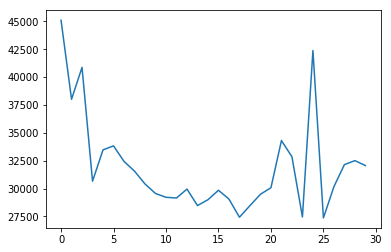

In [146]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
test_